In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.optimize import root_scalar
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
from clock_sim import *

 
warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

f0 = 429e12
h_const = 6.626e-34
G = 6.67e-11
M0 = 2e30
c = 3e8



In [2]:
## Utility



def chirp_constant(Mc):
    return (96/5) * np.pi**(8/3) * (G * Mc / c**3)**(5/3)

def f_t(t, f_0, Mc):
    k = chirp_constant(Mc)
    return (f_0**(-8/3) - (8/3) * k * t)**(-3/8)

def time_to_frequency(f, f_0, Mc):

    k = chirp_constant(Mc)
    return (3 / (8 * k)) * (f_0**(-8/3) - f**(-8/3))

def fit_sine(t, y, yerr=None, f_guess=None):
    """
    Fit y(t) ≈ A * sin(2π f t + phi), zero offset assumed.
    """

    def model(t, A, f, phi):
        return A * np.sin(2*np.pi*f*t + phi)

    # --- guesses ---
    guess_A = (np.max(y) - np.min(y)) / 2

    if f_guess is not None:
        guess_f = f_guess
    else:
        dt = t[1] - t[0]
        freqs = np.fft.rfftfreq(len(t), d=dt)
        fft_mag = np.abs(np.fft.rfft(y))
        guess_f = freqs[np.argmax(fft_mag[1:]) + 1]

    guess_phi = 0.0
    p0 = [guess_A, guess_f, guess_phi]

    popt, pcov = curve_fit(
        model, t, y, p0=p0,
        sigma=yerr,
        absolute_sigma=(yerr is not None)
    )

    perr = np.sqrt(np.diag(pcov))

    return {
        "amplitude": popt[0],
        "amplitude_err": perr[0],
        "frequency": popt[1],
        "frequency_err": perr[1],
        "phase": popt[2],
        "phase_err": perr[2],
    }

def fit_sine_known_f(t, y, f, yerr=None):
    """
    Fit y(t) ≈ A * sin(2π f t + phi), zero offset assumed.
    Frequency f is fixed.
    """

    omega = 2 * np.pi * f

    s = np.sin(omega * t)
    c = np.cos(omega * t)

    if yerr is None:
        # ordinary least squares
        M = np.vstack([s, c]).T
        B, C = np.linalg.lstsq(M, y, rcond=None)[0]
        sigma2 = np.var(y - (B*s + C*c), ddof=2)
        cov = sigma2 * np.linalg.inv(M.T @ M)
    else:
        # weighted least squares
        W = np.diag(1 / yerr**2)
        M = np.vstack([s, c]).T
        cov = np.linalg.inv(M.T @ W @ M)
        B, C = cov @ (M.T @ W @ y)

    A = np.hypot(B, C)
    phi = np.arctan2(C, B)

    # error propagation
    Berr, Cerr = np.sqrt(np.diag(cov))
    Aerr = np.sqrt((B*Berr)**2 + (C*Cerr)**2) / A
    phi_err = np.sqrt((C*Berr)**2 + (B*Cerr)**2) / A**2

    return {
        "amplitude": A,
        "amplitude_err": Aerr,
        "phase": phi,
        "phase_err": phi_err,
    }

In [3]:
##FFD Analysis Functions

def compute_ffd_error(ffds, Ts, sigma_phi):
    """
    Compute mean frequency and separate QPN (1/√N) and laser (1/N²) contributions.

    Parameters
    ----------
    ffds : array_like
        Per-cycle frequency estimates (includes QPN + laser noise)
    Ts : array_like
        Interrogation times for each cycle
    sigma_phi : float
        Per-cycle laser phase noise (radians)

    Returns
    -------
    mean_ffd : float
        Mean frequency
    sigma_QPN_mean : float
        QPN contribution to mean (1/√N)
    sigma_laser_mean : float
        Laser contribution to mean (1/N²)
    err_mean : float
        Total uncertainty on mean
    """

    ffds = np.array(ffds)
    Ts = np.array(Ts)
    N = len(ffds)
    T_total = np.sum(Ts)
    T_mean = np.mean(Ts)

    # 1. Mean
    mean_ffd = np.mean(ffds)

    # 2. Per-cycle QPN estimate
    sigma_total_per_cycle = np.std(ffds, ddof=1)
    sigma_laser_per_cycle = sigma_phi / (2 * np.pi * T_mean)
    sigma_QPN_per_cycle = np.sqrt(max(sigma_total_per_cycle**2 - sigma_laser_per_cycle**2, 0))

    # 3. QPN contribution to mean
    sigma_QPN_mean = sigma_QPN_per_cycle / np.sqrt(N)

    # 4. Laser contribution to mean (telescoping, no dead time)
    sigma_laser_mean = np.sqrt(2) * sigma_phi / (2 * np.pi * T_total)

    # 5. Total error
    err_mean = np.sqrt(sigma_QPN_mean**2 + sigma_laser_mean**2)

    return mean_ffd, sigma_QPN_mean, sigma_laser_mean, err_mean


def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )
def likelihood(X,Y,P1,P2,n):
    N1 = X*n
    l1 = gaussian(N1,P1*n,np.sqrt(n*P1*(1-P1)))
    N2 = Y*n
    l2 = gaussian(N2,P2*n,np.sqrt(n*P2*(1-P2)))
    return l1*l2
        

def make_ellipse(phi,C1,xc,yc):
    phase_com = np.linspace(0,2*np.pi,200)
    P1 = 1/2*(1+np.cos(phase_com))
    P2 = 1/2*(1+np.cos(phase_com+phi))   
    return P1,P2

def likelihood_sum(phi, C1, C2, X, Y, xc, yc, n1, n2, phase_jitter_std = 0 ):
    phase_com = np.linspace(0, 2 * np.pi, 20000)

    # Effective contrasts from jitter
    C1_eff = np.abs(C1) * np.exp(-0.5 * phase_jitter_std**2)
    C2_eff = np.abs(C2) * np.exp(-0.5 * phase_jitter_std**2)

    # Raw P1, P2
    P1 = 0.5 * (1 + C1_eff * np.cos(phase_com))
    P2 = 0.5 * (1 + C2_eff * np.cos(phase_com + phi))

    # Clip to avoid exact 0 or 1
    eps = 1e-10
    P1 = np.clip(P1, eps, 1 - eps)
    P2 = np.clip(P2, eps, 1 - eps)

    # Repeat shapes
    X = np.repeat(X[:, None], len(phase_com), axis=1)
    Y = np.repeat(Y[:, None], len(phase_com), axis=1)
    P1 = np.repeat(P1[None, :], X.shape[0], axis=0)
    P2 = np.repeat(P2[None, :], Y.shape[0], axis=0)

    # QPN variance (in counts)
    sigma1_qpn = np.sqrt(n1 * P1 * (1 - P1))
    sigma2_qpn = np.sqrt(n2 * P2 * (1 - P2))


    # Total sigma (counts)
    sigma1 = np.sqrt(sigma1_qpn**2)
    sigma2 = np.sqrt(sigma2_qpn**2)

    sigma1 = np.where(sigma1 == 0, 1e-12, sigma1)
    sigma2 = np.where(sigma2 == 0, 1e-12, sigma2)

    # Gaussian likelihoods
    likes1 = gaussian(X * n1, P1 * n1, sigma1)
    likes2 = gaussian(Y * n2, P2 * n2, sigma2)
    likes = likes1 * likes2

    # Log likelihood
    loglikes = np.log(np.sum(likes, axis=1) + 1e-300)
    total_likelihood = np.sum(loglikes)
    return total_likelihood


def likelihood_sum_high_res(phi, C1, C2, X, Y, xc, yc, n1, n2, phase_jitter_std = 0 ):
    phase_com = np.linspace(0, 2 * np.pi, 100000)

    # Effective contrasts from jitter
    C1_eff = np.abs(C1) * np.exp(-0.5 * phase_jitter_std**2)
    C2_eff = np.abs(C2) * np.exp(-0.5 * phase_jitter_std**2)

    # Raw P1, P2
    P1 = 0.5 * (1 + C1_eff * np.cos(phase_com))
    P2 = 0.5 * (1 + C2_eff * np.cos(phase_com + phi))

    # Clip to avoid exact 0 or 1
    eps = 1e-10
    P1 = np.clip(P1, eps, 1 - eps)
    P2 = np.clip(P2, eps, 1 - eps)

    # Repeat shapes
    X = np.repeat(X[:, None], len(phase_com), axis=1)
    Y = np.repeat(Y[:, None], len(phase_com), axis=1)
    P1 = np.repeat(P1[None, :], X.shape[0], axis=0)
    P2 = np.repeat(P2[None, :], Y.shape[0], axis=0)

    # QPN variance (in counts)
    sigma1_qpn = np.sqrt(n1 * P1 * (1 - P1))
    sigma2_qpn = np.sqrt(n2 * P2 * (1 - P2))


    # Total sigma (counts)
    sigma1 = np.sqrt(sigma1_qpn**2)
    sigma2 = np.sqrt(sigma2_qpn**2)

    sigma1 = np.where(sigma1 == 0, 1e-12, sigma1)
    sigma2 = np.where(sigma2 == 0, 1e-12, sigma2)

    # Gaussian likelihoods
    likes1 = gaussian(X * n1, P1 * n1, sigma1)
    likes2 = gaussian(Y * n2, P2 * n2, sigma2)
    likes = likes1 * likes2

    # Log likelihood
    loglikes = np.log(np.sum(likes, axis=1) + 1e-300)
    total_likelihood = np.sum(loglikes)
    return total_likelihood




def inverse(x, c):
    return x**(-.5) * c
    


def MLE_optimized_err(data, n1, n2, offset, pll_noise = 0 , g=False, guess=None, cov=False):
    import numpy as np
    import scipy.optimize as sco

    P1 = data[:, 0]
    P2 = data[:, 1]

    # Objective function: negative log-likelihood
    def objective(args):
        [p1] = args
        return -likelihood_sum(p1, 1, 1, np.array(P1), np.array(P2), 0.5, 0.5, n1, n2, phase_jitter_std = pll_noise)

    # Initial guess
    if not g or guess is None:
        guess1 = np.array([offset])
    else:
        guess1 = guess + 1e-4  # Replace epsilon with 1e-4 if not defined

    # Optimization
    opt = sco.minimize(
        objective,
        guess1,
        method='Nelder-Mead',
        options={'disp': False, 'xatol': 1e-9}
    )

    # Wrap and clean phase estimate
    phi_MLE = np.abs(opt.x[0])
    if phi_MLE > np.pi:
        phi_MLE = 2 * np.pi - phi_MLE

    # Compute standard error (if requested)
    if cov:
        h = 1e-5
        try:
            f_plus  = objective([phi_MLE + h])
            f_minus = objective([phi_MLE - h])
            f0      = objective([phi_MLE])
            second_deriv = (f_plus - 2 * f0 + f_minus) / (h ** 2)

            if second_deriv <= 0 or np.isnan(second_deriv):
                phase_jitter_std = np.nan
                print("⚠️ Warning: curvature non-positive or NaN — error estimate invalid.")
            else:
                phase_jitter_std = np.sqrt(1 / second_deriv)
        except:
            phase_jitter_std = np.nan
            print("⚠️ Error computing second derivative — returning NaN for uncertainty.")

        return phi_MLE, phase_jitter_std

    return np.array([phi_MLE])


def MLE_optimized_err_high_res(data, n1, n2, offset, pll_noise = 0 , g=False, guess=None, cov=False):
    import numpy as np
    import scipy.optimize as sco

    P1 = data[:, 0]
    P2 = data[:, 1]

    # Objective function: negative log-likelihood
    def objective(args):
        [p1] = args
        return -likelihood_sum_high_res(p1, 1, 1, np.array(P1), np.array(P2), 0.5, 0.5, n1, n2, phase_jitter_std = pll_noise)

    # Initial guess
    if not g or guess is None:
        guess1 = np.array([offset])
    else:
        guess1 = guess + 1e-4  # Replace epsilon with 1e-4 if not defined

    # Optimization
    opt = sco.minimize(
        objective,
        guess1,
        method='Nelder-Mead',
        options={'disp': False, 'xatol': 1e-9}
    )

    # Wrap and clean phase estimate
    phi_MLE = np.abs(opt.x[0])
    if phi_MLE > np.pi:
        phi_MLE = 2 * np.pi - phi_MLE

    # Compute standard error (if requested)
    if cov:
        h = 1e-5
        try:
            f_plus  = objective([phi_MLE + h])
            f_minus = objective([phi_MLE - h])
            f0      = objective([phi_MLE])
            second_deriv = (f_plus - 2 * f0 + f_minus) / (h ** 2)

            if second_deriv <= 0 or np.isnan(second_deriv):
                phase_jitter_std = np.nan
                print("⚠️ Warning: curvature non-positive or NaN — error estimate invalid.")
            else:
                phase_jitter_std = np.sqrt(1 / second_deriv)
        except:
            phase_jitter_std = np.nan
            print("⚠️ Error computing second derivative — returning NaN for uncertainty.")

        return phi_MLE, phase_jitter_std

    return np.array([phi_MLE])


def QPN_sim(p,n,C=1):
    return np.random.binomial(n,p)/n



def clock_average(signals,Ts,N = 1e7,offset = np.pi/10):
    C = 1
    P1 = []
    P2 = []
    pll_noise = laser_phase_noise(0.01,1e-9,1)
    phi_start = np.random.normal(0,pll_noise)
    for signal,T in tqdm(zip(signals,Ts), leave = False):
        phase_com =2*np.pi*np.random.rand(1)
        p1 = 1/2*(1+C*np.cos(phase_com))
        p1 = QPN_sim(p1,N,C)
        P1.append(p1)
        ffd = signal
        phi_end = np.random.normal(0,pll_noise)
        p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
        phi_start = phi_end
        p2 = QPN_sim(p2,N,C)
        P2.append(p2)
    P1 = np.squeeze(P1)
    P2 = np.squeeze(P2)
    
    data = np.array(list(zip(P1,P2)))
    opt = MLE_optimized_err(data,N,N,offset,cov = True)
    phi_measured = opt[0]
    phi_err = opt[1]
    return np.array(phi_measured)-offset,np.array(phi_err)


def single_point_estimator(P1,P2,N,T,offset = np.pi/10):
    
    sub_ellipse_P1 = [np.squeeze(np.array(P1))]
    sub_ellipse_P2 = [np.squeeze(np.array(P2))]
    data = np.array(list(zip(sub_ellipse_P1, sub_ellipse_P2)))
    opt = MLE_optimized_err(data,N,N,offset,cov = True)
    return opt

def clock_average_single_point(signals,Ts,spin_echo = True, N = 1e7,offset = np.pi/10):
    C = 1
    P1 = []
    P2 = []
    ffds = []
    pll_noise = laser_phase_noise(0.01,2e-7,1)
    phi_start = np.random.normal(0,pll_noise)
    for signal,T in tqdm(zip(signals,Ts), leave = False):
        phase_com =2*np.pi*np.random.rand(1)
        p1 = 1/2*(1+C*np.cos(phase_com))
        p1 = QPN_sim(p1,N,C)
        ffd = signal
        phi_end = np.random.normal(0,pll_noise)
        phi_pi = 2*np.random.normal(0,pll_noise)
        if spin_echo == False:
            phi_pi = 0 
        p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset-(phi_end-phi_start+phi_pi)))
        phi_start = phi_end
        p2 = QPN_sim(p2,N,C)
        opt = single_point_estimator(p1,p2,N,T,offset)
        ffds.append((opt[0]-offset)/(T*f0*2*np.pi))

    total_noise_per_cycle = np.std(ffds)    
    ffd_mean_err = total_noise_per_cycle/np.sqrt(len(ffds))
    
    
    return np.mean(ffds), ffd_mean_err

    



In [4]:


def smooth_abs(x, eps=1e-12):
    return np.sqrt(x**2 + eps)


def dd_window(size, n_pi_pulses):
    """
    Evenly spaced window alternating between 1 and -1.
    
    Parameters
    ----------
    size : int
        Total length of the array.
    n_switches : int
        Number of times to switch sign.
    """
    # total number of segments
    segments = n_pi_pulses + 1
    
    # index for each point
    idx = np.arange(size)
    
    # figure out which segment each index belongs to
    seg = (idx * segments) // size   # integer division
    
    # alternate signs: start at +1, flip each segment
    return (-1) ** seg

def find_T_minimize(t0, f_chirp,d = 1e10):
    """
    Find cycle duration by minimizing the waveform difference.
    """
    def cycle_err(T_array):
        T = T_array[0]  # extract scalar from array
        cyc_start = h_chirped(t0, 1, f_chirp(t0), 0) - h_chirped(t0 + d/c, 1, f_chirp(t0 + d/c), 0)
        cyc_end   = h_chirped(t0 + T, 1, f_chirp(t0+T), 0) - h_chirped(t0 + T + d/c, 1, f_chirp(t0 + T + d/c), 0)
        return smooth_abs(cyc_start - cyc_end)
    T0 = np.array([1 / f_chirp(t0)])

    res = sco.minimize(cycle_err, T0, bounds=[(0, None)], method='Nelder-Mead')

    if not res.success:
        raise RuntimeError("Minimization failed: " + res.message)
    
    return res.x[0]

def find_T_minimize_half_cycle(t0, f_chirp,d = 1e10):
    """
    Find cycle duration by minimizing the waveform difference.
    """
    def cycle_err(T_array):
        T = T_array[0]  # extract scalar from array
        cyc_start = h_chirped(t0, 1, f_chirp(t0), 0) - h_chirped(t0 + d/c, 1, f_chirp(t0 + d/c), 0)
        cyc_end   = h_chirped(t0 + T, 1, f_chirp(t0+T), 0) - h_chirped(t0 + T + d/c, 1, f_chirp(t0 + T + d/c), 0)
        return smooth_abs(cyc_start - cyc_end)
    T0 = np.array([1 / f_chirp(t0)])

    res = sco.minimize(cycle_err, T0, bounds=[(0, None)], method='Nelder-Mead')

    if not res.success:
        raise RuntimeError("Minimization failed: " + res.message)
    
    return res.x[0]/2


def h_chirped(t,H,f,phi):
    return H*np.sin(2*np.pi*f*t+phi)

def gw(t0,T,d = 1e10):
    ts = np.linspace(t0,t0+T,10000)
    s = 1/2*(h(ts)-h(ts+d/c))
    return (ts,s) 


def signal_chirped(t0,f_chirp,H= 1e-20,phi = 0,spin_echo = True,fixed_T = False, T = 100, optimized_T = True,d = 1e10):
    if fixed_T == False:
        T = 1/f_chirp(t0)
    if optimized_T:
        T = find_T_minimize(t0,f_chirp)
        
    if spin_echo == False:
        T = find_T_minimize_half_cycle(t0,f_chirp)

       
    ts = np.linspace(t0,t0+T,40000)
    dt = ts[1]-ts[0]
    s = h_chirped(ts,H,f_chirp(ts),phi)-h_chirped(ts-d/c,H,f_chirp(ts-d/c),phi)
    s_bar = np.sum((1/T * s*dt))
    if spin_echo == True:
        s_bar = np.sum((1/T * s*dt)*dd_window(len(s),1))
    return (s_bar,T)


def signal_time(t0,f_chirp,H= 1e-20,phi = 0,spin_echo = True,fixed_T = False, T = 100, optimized_T = True,d = 1e10):
    if fixed_T == False:
        T = 1/f_chirp(t0)
    if optimized_T:
        T = find_T_minimize(t0,f_chirp)
        
    if spin_echo == False:
        T = find_T_minimize_half_cycle(t0,f_chirp)

    return T



def optimal_bandwidth(linewidth, laser_power, qe):
    return np.sqrt(qe*laser_power*linewidth/(h_const*f0))

def laser_phase_noise(linewidth, laser_power, qe):
    # bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    var_phi = h_const*f0*bandwidth/(qe*laser_power)+(linewidth/bandwidth)
    return np.sqrt(var_phi/2)



def generate_signals(f0=0.01, N_measurements=1200, M_chirp=500, phi=0, t0=0, amp = 1e-20, fixed_T=False, optimized_T=True,d = 1e10,spin_echo = True):
    t = np.linspace(-1000, 240*3600, 100000)
    Mc = M_chirp * M0
    
    from scipy.interpolate import interp1d
    f = f_t(t, f0, Mc)
    f_chirp = interp1d(t, f)
    
    signals = []
    t0s1 = []
    Ts = []
    
    for i in range(N_measurements):
        s_bar, T = signal_chirped(
            t0,
            H=amp,
            f_chirp=f_chirp,
            phi=phi,
            spin_echo=spin_echo,
            fixed_T=fixed_T,
            optimized_T=optimized_T,
            d = d
        )
        t0 += T
        t0s1.append(t0)
        signals.append(s_bar)
        Ts.append(T)
    
    return signals, Ts



    

In [5]:
def measurement_time(f_gw,M_chirp,N_cycles):
    t = np.linspace(0, 240*3600, 100000)
    Mc = M_chirp * M0
    
    from scipy.interpolate import interp1d
    f = f_t(t, f_gw, Mc)
    f_chirp = interp1d(t, f)
    
    signals = []
    t0s1 = []
    Ts = []
    t0 = 0
    for i in range(N_cycles):
        T = signal_time(
            t0,
            H=1,
            f_chirp=f_chirp,
            phi=0,
            spin_echo=True,
            fixed_T=False,
            optimized_T=True,
            d = 1
        )
        t0 += T
        t0s1.append(t0)
        Ts.append(T)
    return np.sum(Ts)
    

In [34]:
def compute_complex_response(
    positions,
    arms,          # here: photon propagation directions n̂
    arm_lengths,
    f_gw,          
    A_plus,
    A_cross,
    theta,
    phi_sky,
    psi=0
):
    # GW propagation vector
    k = -np.array([
        np.sin(theta) * np.cos(phi_sky),
        np.sin(theta) * np.sin(phi_sky),
        np.cos(theta)
    ])

    # Basis vectors perpendicular to k
    if np.allclose(k, [0, 0, 1]):
        ex = np.array([1.0, 0.0, 0.0])
    else:
        ex = np.cross([0, 0, 1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)

    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)

    # Rotate by polarization angle psi
    e_plus_rot  = e_plus * np.cos(2 * psi) + e_cross * np.sin(2 * psi)
    e_cross_rot = -e_plus * np.sin(2 * psi) + e_cross * np.cos(2 * psi)

    # --- CLOCK ANTENNA GEOMETRY ---
    # n̂ = photon propagation direction
    nk = np.einsum("di,i->d", arms, k)
    denom = 1.0 - nk

    # Geometry-only detector tensor
    D = 0.5 * np.einsum("di,dj->dij", arms, arms) / denom[:, None, None]

    # Antenna factors
    F_plus  = np.einsum("dij,ij->d", D, e_plus_rot)
    F_cross = np.einsum("dij,ij->d", D, e_cross_rot)

    # Keep original phase convention
    tau = np.dot(positions, k) / c

    # Pure antenna-pattern response (no transfer function)
    S = (F_plus * A_plus + F_cross * A_cross) * np.exp(-1j * 2 * np.pi * f_gw * tau)
    
    

    return S, nk

def compute_fd_complex_response(
    positions,
    arms,          # here: photon propagation directions n̂
    arm_lengths,
    f_gw,          
    A_plus,
    A_cross,
    theta,
    phi_sky,
    psi=0
):
    # GW propagation vector
    k = -np.array([
        np.sin(theta) * np.cos(phi_sky),
        np.sin(theta) * np.sin(phi_sky),
        np.cos(theta)
    ])

    # Basis vectors perpendicular to k
    if np.allclose(k, [0, 0, 1]):
        ex = np.array([1.0, 0.0, 0.0])
    else:
        ex = np.cross([0, 0, 1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)

    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)

    # Rotate by polarization angle psi
    e_plus_rot  = e_plus * np.cos(2 * psi) + e_cross * np.sin(2 * psi)
    e_cross_rot = -e_plus * np.sin(2 * psi) + e_cross * np.cos(2 * psi)

    # --- CLOCK ANTENNA GEOMETRY ---
    # n̂ = photon propagation direction
    nk = np.einsum("di,i->d", arms, k)
    denom = 1.0 - nk

    # Geometry-only detector tensor
    D = 0.5 * np.einsum("di,dj->dij", arms, arms) / denom[:, None, None]

    # Antenna factors
    F_plus  = np.einsum("dij,ij->d", D, e_plus_rot)
    F_cross = np.einsum("dij,ij->d", D, e_cross_rot)

    # Keep original phase convention
    tau = np.dot(positions, k) / c
    
    phase_delay = 2 * np.pi * f_gw * arm_lengths * denom / c
    transfer = 1.0 - np.exp(-1j * phase_delay)
    
    # Pure antenna-pattern response (no transfer function)
    S = (F_plus * A_plus + F_cross * A_cross) * np.exp(-1j * 2 * np.pi * f_gw * tau) * transfer
    
    

    return S, nk

def single_band_network_response(positions, arms, f_gw1, N_cycles_1, A_plus, A_cross, theta_sky, phi_sky,psi,M_chirp =500, arm_lengths = [1e10,1e10,1e10],n_ensembles = 10):
    S, nk = compute_complex_response(positions, arms, f_gw1 ,A_plus, A_cross, theta_sky, phi_sky,psi)
    eff_arm_lengths =np.array(arm_lengths)*(1-nk)
    fits = []
    sigs = []
    for s,d in zip(S,eff_arm_lengths):
        f_measured = []
        f_true = []
        f_err = []
        t_starts = np.linspace(0,1/(f_gw1),n_ensembles)
        for t0 in tqdm(t_starts):    
            signals,Ts = generate_signals(f0=f_gw1, N_measurements=N_cycles_1, M_chirp=M_chirp, t0 = t0, phi=np.angle(s), amp = np.abs(s)*5e-20,d = d)
            ffd_mean,ffd_err = clock_average_single_point(signals,Ts)    
            f_measured.append(ffd_mean)
            f_true.append(np.mean(signals))
            f_err.append(ffd_err)
        plt.errorbar(t_starts,f_measured,f_err,marker='o', markersize=6,elinewidth=1.5,capsize = 3,
                    linestyle='none')   
        fits.append(fit_sine_known_f(t_starts, f_measured, yerr=np.array(f_err),f = f_gw1))
        sigs.append(fit_sine_known_f(t_starts, f_true, yerr=np.array(f_err)/1e3, f = f_gw1))
    T_1 = np.sum(Ts)
    
    fit_S = []
    true_S =[]
    phase_err = []
    rel_amp_err = []
    for fit in fits:
            fit_S.append(fit['amplitude']*np.exp(1j*fit['phase']))
            phase_err.append(fit['phase_err'])
            rel_amp_err.append(np.abs(fit['amplitude_err']/fit['amplitude']))
    
    for sig in sigs:
            true_S.append(sig['amplitude']*np.exp(1j*sig['phase']))
            
    
    

    return fit_S,T_1,rel_amp_err,phase_err,true_S


  

In [17]:
##Source Setup

M_chirp  = 1000 ##In Solar Masses (Start at 500, go up to 2000)


##Natural_Polarization_Frame
inc_angle =np.pi/3

A_plus  = np.cos(inc_angle)
A_cross = (1+np.cos(inc_angle)**2)/2

##Rotating into detector frame 
psi  = np.pi/3 


##Sky Location
theta_sky  = 0.5
phi_sky  = 0.7




##Measurement Cycles
f_gw1 = 1/100 ##Keep this in the 10s of mHz 
f_gw2 = 2/100 ## Select this such that T_12 is not more than 10 days?
## Make a few data sets where the distinction 

#Network Setup
d1 = 1e10
d2 = 1e10
d3 = 1e10
n_ensembles = 10
theta_1 = 0 
theta_2 = np.pi/3
theta_3 = np.pi/6
r = 1.46e11 
positions = np.array([[r*np.cos(theta_1),r*np.sin(theta_1),0],[r*np.cos(theta_2),r*np.sin(theta_2),0],[r*np.cos(theta_3),r*np.sin(theta_3),0]])
arms = np.array([[np.sin(theta_1),np.cos(theta_1),0],[np.sin(theta_2),np.cos(theta_2),0],[np.sin(theta_3),np.cos(theta_3),0]])

T_12 = time_to_frequency(f_gw2, f_gw1, M_chirp*M0)
print(T_12/86400)

###After traversing from f1 to f2

theta_1 = 0 + T_12/86400*1/365
theta_2 = np.pi/3 + T_12/86400*1/365
theta_3 = np.pi/6 + T_12/86400*1/365

positions_2 = np.array([[r*np.cos(theta_1),r*np.sin(theta_1),0],[r*np.cos(theta_2),r*np.sin(theta_2),0],[r*np.cos(theta_3),r*np.sin(theta_3),0]])
arms_2 = np.array([[np.sin(theta_1),np.cos(theta_1),0],[np.sin(theta_2),np.cos(theta_2),0],[np.sin(theta_3),np.cos(theta_3),0]])


N_cycles_1 = 2000
N_cycles_2 = 2000




13.52295253512601


In [18]:
#fits has a sine wave with error on it, note down amplitude, phase and relative errors. 

#Make a dict with all the setup parameters, fits1 and fits2. 

## How to extract theta_sky and phi_sky from fits paramaters (errors). 


In [19]:
##Source Setup

M_chirp  = 1000 ##In Solar Masses (Start at 500, go up to 2000)


##Natural_Polarization_Frame
inc_angle =np.pi/3

A_plus  = np.cos(inc_angle)
A_cross = (1+np.cos(inc_angle)**2)/2

##Rotating into detector frame 
psi  = np.pi/3 


##Sky Location
theta_sky  = -0.5
phi_sky  = -0.7




##Measurement Cycles
f_gw1 = 1/100 ##Keep this in the 10s of mHz 
## Make a few data sets where the distinction 

#Network Setup
d1 = 1e10

n_ensembles = 5
theta_1 = 0 

r = 1.46e11 
positions = np.array([[r*np.cos(theta_1),r*np.sin(theta_1),0]])
arms = np.array([[np.sin(theta_1),np.cos(theta_1),0]])




N_cycles = [50,100,500,1000,2000]




In [20]:
# fit_Ss = []
# T_1s = []
# amp_errs =[]
# phase_errs = []
# true_Ss= []
# for n_cycles in N_cycles:
#     fit_S,T_1,amp_err,phase_err,true_S = single_band_network_response(positions, arms, f_gw1, n_cycles, A_plus, A_cross, theta_sky, phi_sky,psi,M_chirp,n_ensembles = n_ensembles,arm_lengths = [1e10])
#     fit_Ss.append(fit_S)
#     T_1s.append(T_1)
#     amp_errs.append(amp_err)
#     phase_errs.append(phase_err)
#     true_Ss.append(true_S)

In [21]:
# fit_S,T_1,amp_err,phase_err,true_S = single_band_network_response(positions, arms, f_gw1, 50, A_plus, A_cross, theta_sky, phi_sky,psi,M_chirp,n_ensembles = n_ensembles,arm_lengths = [1e10])
# fit_Ss[0]=(fit_S)
# T_1s[0]=(T_1)
# amp_errs[0]=(amp_err)
# phase_errs[0]=(phase_err)
# true_Ss[0]=(true_S)


# fit_S,T_1,amp_err,phase_err,true_S = single_band_network_response(positions, arms, f_gw1, 150, A_plus, A_cross, theta_sky, phi_sky,psi,M_chirp,n_ensembles = n_ensembles,arm_lengths = [1e10])
# fit_Ss[1]=(fit_S)
# T_1s[1]=(T_1)
# amp_errs[1]=(amp_err)
# phase_errs[1]=(phase_err)
# true_Ss[1]=(true_S)

In [23]:
# plt.plot(np.array(T_1s)/3600,1e3*np.array(phase_errs),'o-')
# plt.xlabel('Averaging Time [Hours]')
# plt.ylabel('Phase Uncertainty $\sigma_\phi$ [mrad]')
# plt.savefig('plots/phase_uncertainty.pdf',bbox_inches = 'tight')
# plt.figure()
# plt.plot(np.array(T_1s)/3600,amp_errs,'o-',color = RED)
# plt.xlabel('Averaging Time [Hours]')
# plt.ylabel('Relative Amplitude Uncertainty $\sigma_A/A$')
# plt.savefig('plots/amplitude_uncertainty.pdf',bbox_inches = 'tight')

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

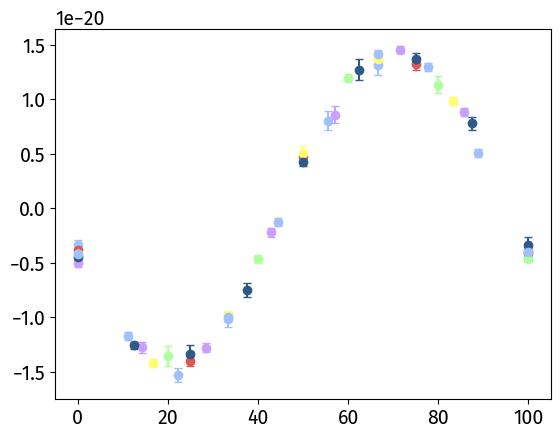

In [37]:
fit_Ss = []
T_1s = []
amp_errs =[]
phase_errs = []
true_Ss= []
N_ensembles = [4,5,6,7,8,9,10]
for n_ensembles in N_ensembles:
    fit_S,T_1,amp_err,phase_err,true_S = single_band_network_response(positions, arms, f_gw1, 100, A_plus, A_cross, theta_sky, phi_sky,psi,M_chirp,n_ensembles = n_ensembles,arm_lengths = [1e10])
    fit_Ss.append(fit_S)
    T_1s.append(T_1)
    amp_errs.append(amp_err)
    phase_errs.append(phase_err)
    true_Ss.append(true_S)

[2.77010289 2.77010289 2.77010289 2.77010289 2.77010289 2.77010289
 2.77010289]


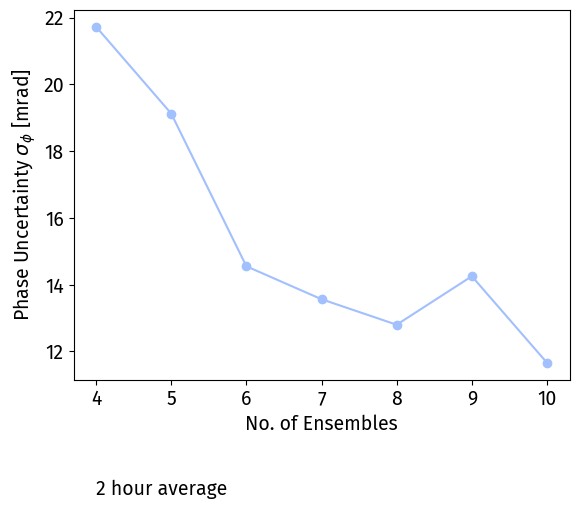

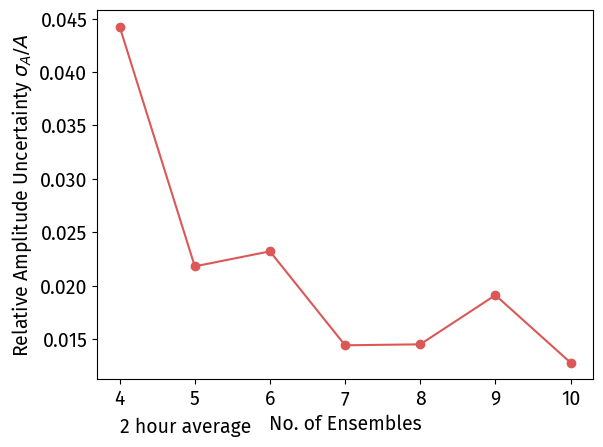

In [38]:

plt.plot(np.array(N_ensembles),np.array(phase_errs)*1e3,'o-')
plt.xlabel('No. of Ensembles')
plt.ylabel('Phase Uncertainty $\sigma_\phi$ [mrad]')
plt.text(4,7.7,'%d hour average'%(T_1s[0]/3600))
# plt.savefig('plots/phase_uncertainty_n_ensembles.pdf',bbox_inches = 'tight')
plt.figure()
plt.plot(np.array(N_ensembles),amp_errs,'o-',color = RED)
plt.xlabel('No. of Ensembles')
plt.ylabel('Relative Amplitude Uncertainty $\sigma_A/A$')
plt.text(4,6.2e-3,'%d hour average'%(T_1s[0]/3600))
# plt.savefig('plots/amplitude_uncertainty_n_ensembles.pdf',bbox_inches = 'tight')
print(np.array(T_1s)/3600)